In [1]:
from sstadex import Macromodel, Primitive, Test, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim, diffpair_cc, current_mirror_cc, common_source
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify
from sstadex import Transistor
import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

In [3]:
import sys

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

In [108]:
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]
currents = [10e-6, 20e-6, 30e-6, 40e-6]

gm = []
Ro = []
cin = []
cout = []
W = []
L = []
gain = []
gmid = []
id = []

for i in currents:
    common_source_prim = common_source(netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': (-1.8, -0.2, 0.01), 
        'vgs_lut': (-1.7, -0.2, 0.01), 
        'vgs': np.linspace(-1.7, -0.3, 10), 
        'vds': np.linspace(-1.7, -0.3, 10), 
        'il': i,
        'length': lengths, 
        '2d_var': ['vds', 'vgs']},
    conf=0)

    common_source_prim.build()
    
    gm.append(np.asarray(common_source_prim.gm).flatten())
    Ro.append(np.asarray(common_source_prim.Ro).flatten())
    W.append(np.asarray(common_source_prim.W).flatten())
    L.append(np.asarray(common_source_prim.L).flatten())
    gain.append(20*np.log10(np.asarray(common_source_prim.gm).flatten()*np.asarray(common_source_prim.Ro).flatten()))
    gmid.append(np.asarray(common_source_prim.gm).flatten()/i)
    id.append(np.repeat(i, len(np.asarray(common_source_prim.W).flatten())))
    cin.append(np.asarray(common_source_prim.cgg).flatten()+np.asarray(common_source_prim.gm).flatten()*np.asarray(common_source_prim.Ro).flatten()*np.asarray(common_source_prim.cgd).flatten())
    cout.append(np.abs(np.asarray(common_source_prim.cgd).flatten()))

vds
vgs
1
vds
vgs
1
vds
vgs
1
vds
vgs
1


In [109]:
common_source_dict = {
    'gm': np.asarray(gm).flatten(),
    'Ro': np.asarray(Ro).flatten(),
    "W": np.asarray(W).flatten(),
    "L": np.asarray(L).flatten(),
    "gain": np.asarray(gain).flatten(),
    "gmid": np.asarray(gmid).flatten(),
    "id": np.asarray(id).flatten(),
    "area": np.asarray(W).flatten()+np.asarray(L).flatten(),
    "cin": np.asarray(cin).flatten(),
    "cout": np.asarray(cout).flatten()}

common_source_df = pd.DataFrame.from_dict(common_source_dict)
common_source_df

,gm,Ro,W,L,gain,gmid,id,area,cin,cout
0,0.000012,2.122213e+06,7.879063e-08,4.000000e-07,28.418248,1.242005,0.00001,4.787906e-07,3.653097e-16,4.921442e-18
1,0.000015,2.052492e+06,9.785620e-08,4.000000e-07,29.522382,1.458269,0.00001,4.978562e-07,4.540639e-16,5.364014e-18
2,0.000017,1.961476e+06,1.263948e-07,4.000000e-07,30.698376,1.747172,0.00001,5.263948e-07,5.818910e-16,5.897876e-18
3,0.000021,1.833789e+06,1.722144e-07,4.000000e-07,31.907372,2.147926,0.00001,5.722144e-07,7.750545e-16,6.545461e-18
4,0.000027,1.650219e+06,2.531915e-07,4.000000e-07,33.080553,2.732034,0.00001,6.531915e-07,1.089241e-15,7.355221e-18
...,...,...,...,...,...,...,...,...,...,...
195,0.000132,2.401200e+06,2.032179e-05,6.400000e-06,50.023763,3.301413,0.00004,2.672179e-05,1.479238e-12,1.080129e-15
196,0.000184,1.864805e+06,3.727632e-05,6.400000e-06,50.705887,4.598339,0.00004,4.367632e-05,2.495147e-12,1.287295e-15
197,0.000285,1.288790e+06,9.073666e-05,6.400000e-06,51.300365,7.124857,0.00004,9.713666e-05,5.473497e-12,1.826024e-15
198,0.000539,8.110656e+05,4.145444e-04,6.400000e-06,52.808051,13.467487,0.00004,4.209444e-04,2.051946e-11,3.527526e-15


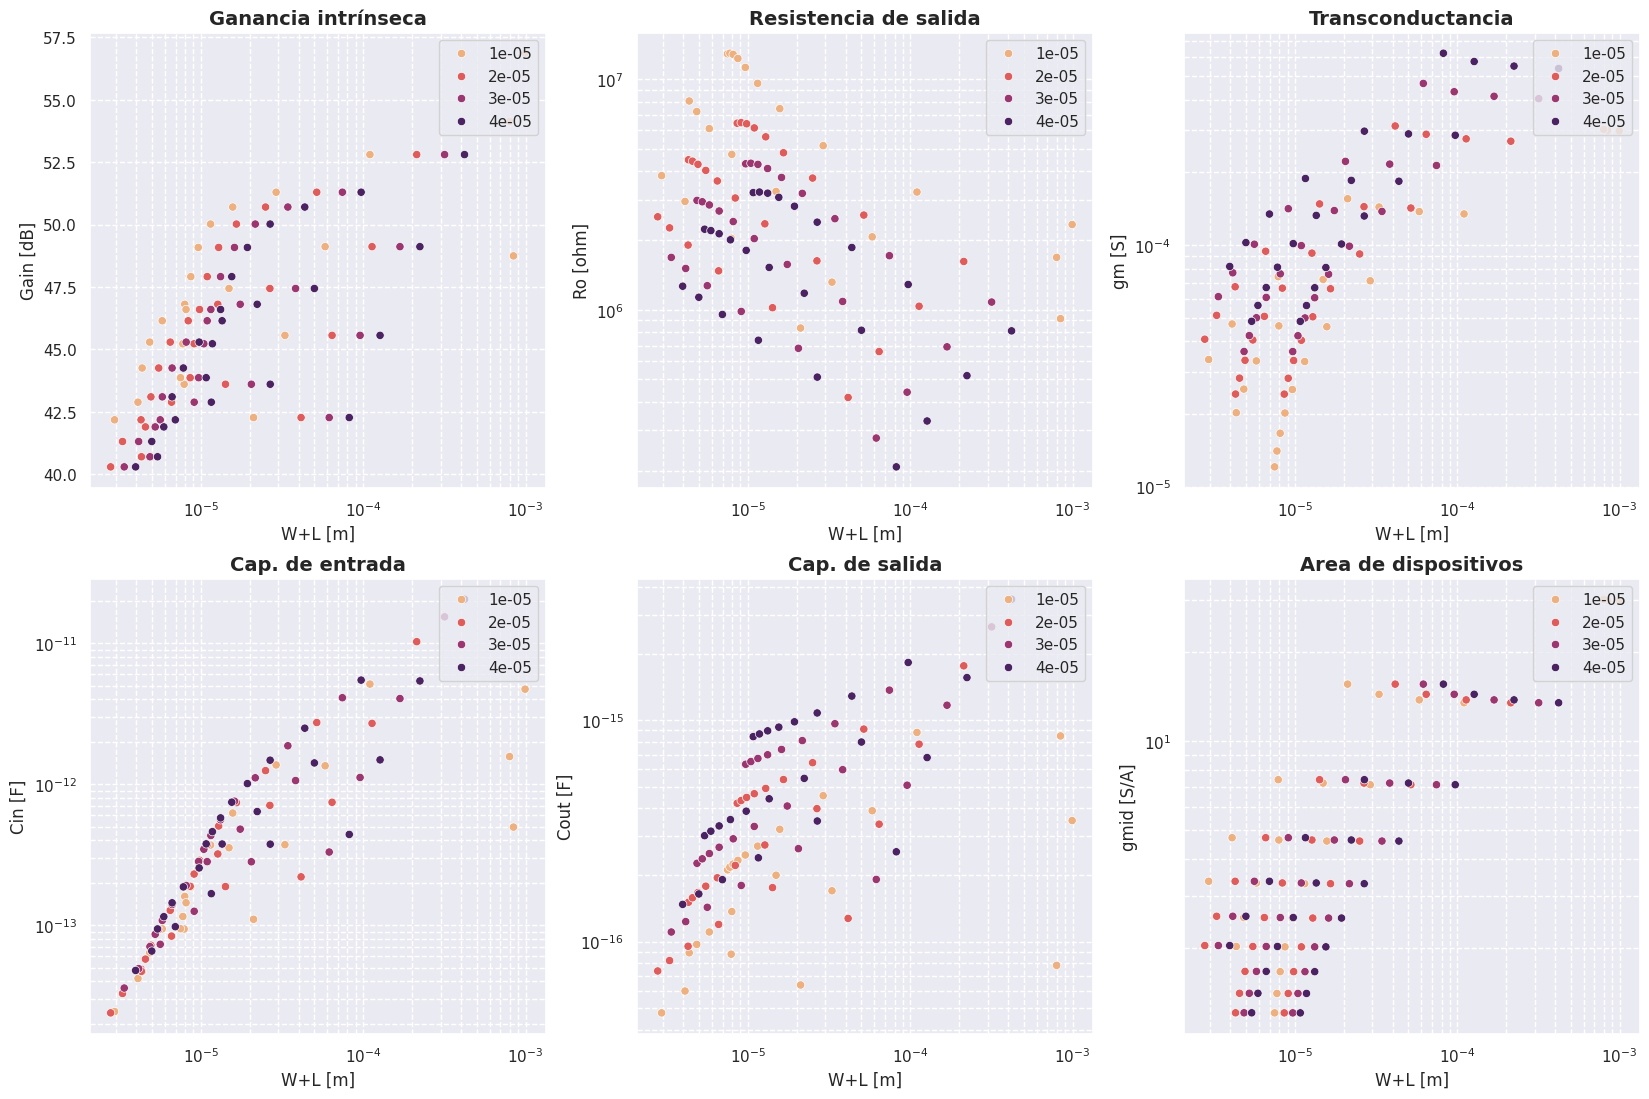

In [123]:
fig, axs = plt.subplots(2, 3, figsize=(20, 13))
sns.scatterplot(ax=axs[0,0], data=common_source_df, x="area", y = "gain", hue="id", palette='flare')
sns.scatterplot(ax=axs[0,1], data=common_source_df, x="area", y = "Ro", hue="id", palette='flare')
sns.scatterplot(ax=axs[0,2], data=common_source_df, x="area", y = "gm", hue="id", palette='flare')
sns.scatterplot(ax=axs[1,0], data=common_source_df, x="area", y = "cin", hue="id", palette='flare')
sns.scatterplot(ax=axs[1,1], data=common_source_df, x="area", y = "cout", hue="id", palette='flare')
sns.scatterplot(ax=axs[1,2], data=common_source_df, x="area", y = "gmid", hue="id", palette='flare')

axs[0,0].set_title(r"Ganancia intrínseca", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"W+L [m]")
axs[0,0].set_ylabel(r"Gain [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Resistencia de salida", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"W+L [m]")
axs[0,1].set_ylabel(r"Ro [ohm]")
axs[0,1].legend(loc = 'upper right')

axs[0,2].set_xlabel(r"W+L [m]")
axs[0,2].set_ylabel(r"gm [S]")
axs[0,2].set_title(r"Transconductancia", fontsize=14, weight='bold')
axs[0,2].legend(loc = 'upper right')

axs[1,0].set_title(r"Cap. de entrada", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"W+L [m]")
axs[1,0].set_ylabel(r"Cin [F]")
axs[1,0].legend(loc = 'upper right')

axs[1,1].set_title(r"Cap. de salida", fontsize=14, weight='bold')
axs[1,1].set_xlabel(r"W+L [m]")
axs[1,1].set_ylabel(r"Cout [F]")
axs[1,1].legend(loc = 'upper right')

axs[1,2].set_title(r"Area de dispositivos", fontsize=14, weight='bold')
axs[1,2].set_xlabel(r"W+L [m]")
axs[1,2].set_ylabel(r"gmid [S/A]")
axs[1,2].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[0,2].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')
axs[1,2].set_xscale('log')

axs[0,1].set_yscale('log')
axs[0,2].set_yscale('log')
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[1,2].set_yscale('log')


axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[0,2].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  
axs[1,2].grid(True,which="both",ls="--")  

plt.savefig('primitives_LUTs.svg', dpi=120)

In [115]:
#common_source_df = common_source_df[(common_source_df["gain"]>40) & (common_source_df["Ro"]>1e6) & (common_source_df["area"]<1e-4) & (common_source_df["W"]>1e-6)]
common_source_df = common_source_df[(common_source_df["gain"]>40) & (common_source_df["W"]<1e-3) & (common_source_df["W"]>1e-6)]

In [116]:
new_df = common_source_df[["area", "id", "gain"]]
new_df

,area,id,gain
9,0.000843,0.00001,48.748727
18,0.000021,0.00001,42.270635
19,0.000797,0.00001,54.129481
25,0.000003,0.00001,42.180040
26,0.000004,0.00001,42.886844
...,...,...,...
194,0.000019,0.00004,49.087133
195,0.000027,0.00004,50.023763
196,0.000044,0.00004,50.705887
197,0.000097,0.00004,51.300365


In [117]:
mask = pareto.paretoset(new_df, ["min", "min", "max"])

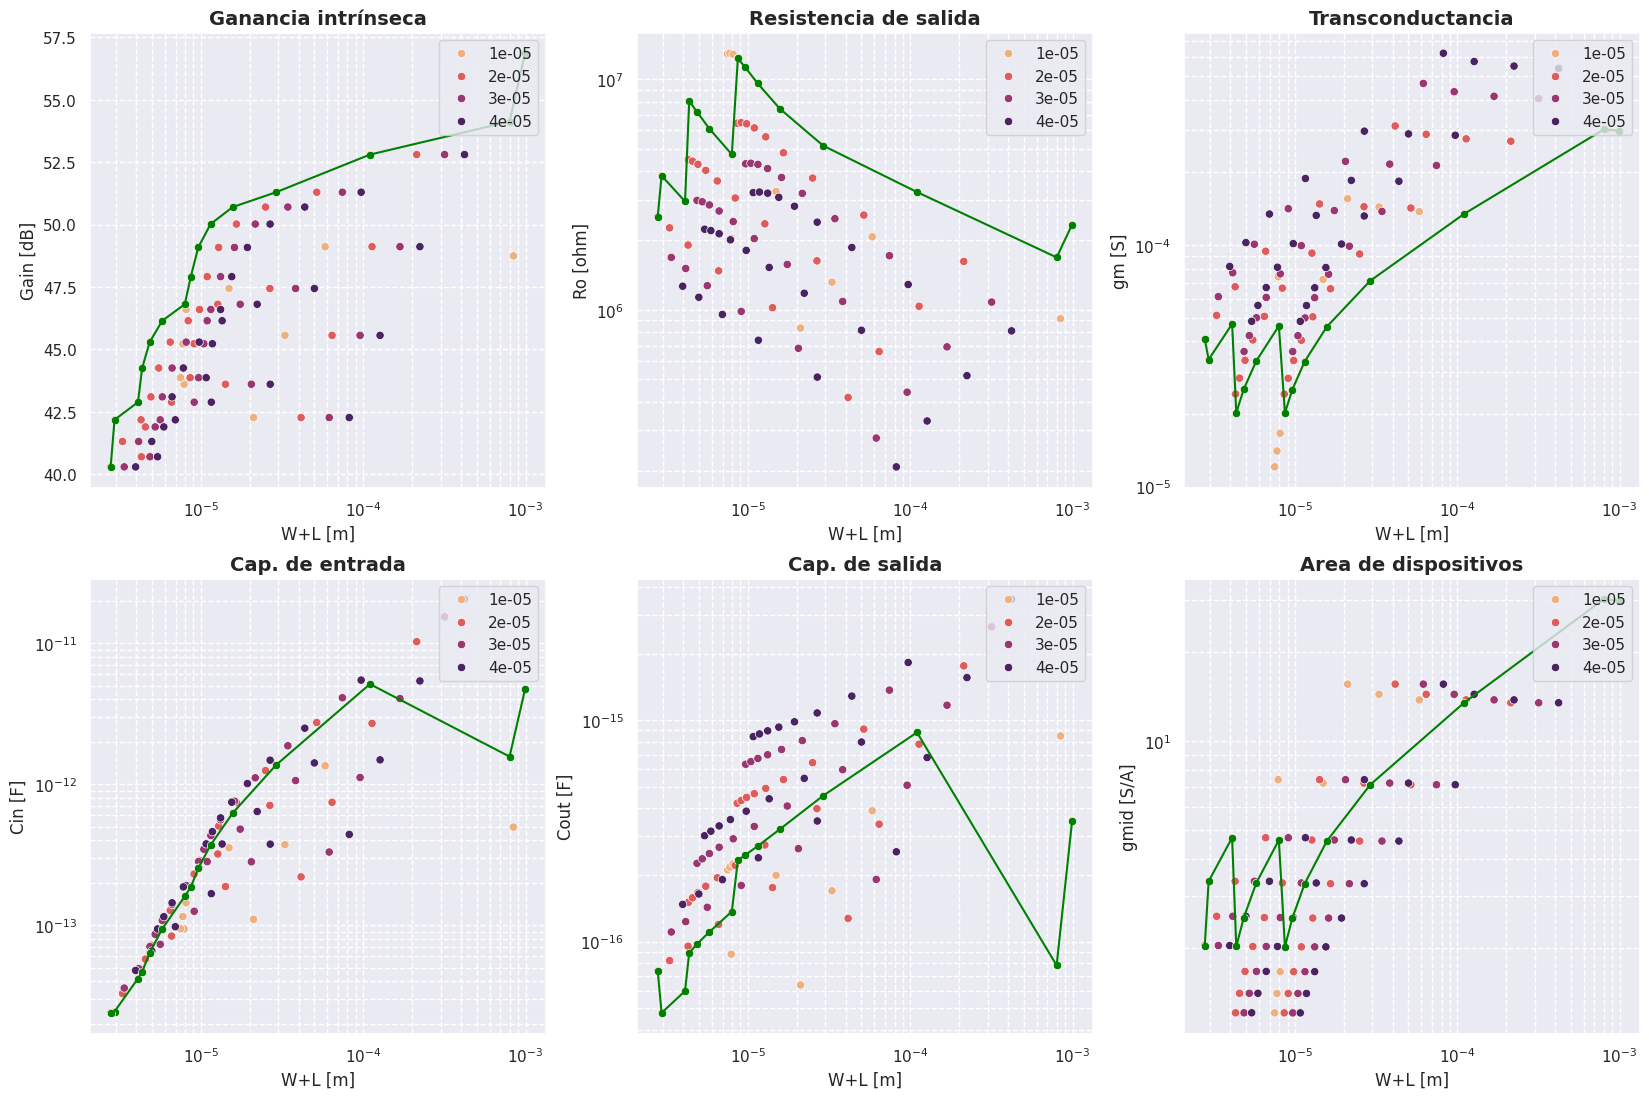

In [124]:
fig, axs = plt.subplots(2, 3, figsize=(20, 13))
sns.scatterplot(ax=axs[0,0], data=common_source_df, x="area", y = "gain", hue="id", palette='flare')
sns.scatterplot(ax=axs[0,0], data=common_source_df[mask], x="area", y = "gain", c='green')
sns.lineplot(ax=axs[0,0], data=common_source_df[mask], x="area", y = "gain", c='green')
sns.scatterplot(ax=axs[0,1], data=common_source_df, x="area", y = "Ro", hue="id", palette='flare')
sns.scatterplot(ax=axs[0,1], data=common_source_df[mask], x="area", y = "Ro", c='green')
sns.lineplot(ax=axs[0,1], data=common_source_df[mask], x="area", y = "Ro", c='green')
sns.scatterplot(ax=axs[0,2], data=common_source_df, x="area", y = "gm", hue="id", palette='flare')
sns.scatterplot(ax=axs[0,2], data=common_source_df[mask], x="area", y = "gm", c='green')
sns.lineplot(ax=axs[0,2], data=common_source_df[mask], x="area", y = "gm", c='green')
sns.scatterplot(ax=axs[1,0], data=common_source_df, x="area", y = "cin", hue="id", palette='flare')
sns.scatterplot(ax=axs[1,0], data=common_source_df[mask], x="area", y = "cin", c='green')
sns.lineplot(ax=axs[1,0], data=common_source_df[mask], x="area", y = "cin", c='green')
sns.scatterplot(ax=axs[1,1], data=common_source_df, x="area", y = "cout", hue="id", palette='flare')
sns.scatterplot(ax=axs[1,1], data=common_source_df[mask], x="area", y = "cout", c='green')
sns.lineplot(ax=axs[1,1], data=common_source_df[mask], x="area", y = "cout", c='green')
sns.scatterplot(ax=axs[1,2], data=common_source_df, x="area", y = "gmid", hue="id", palette='flare')
sns.scatterplot(ax=axs[1,2], data=common_source_df[mask], x="area", y = "gmid", c='green')
sns.lineplot(ax=axs[1,2], data=common_source_df[mask], x="area", y = "gmid", c='green')

axs[0,0].set_title(r"Ganancia intrínseca", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"W+L [m]")
axs[0,0].set_ylabel(r"Gain [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Resistencia de salida", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"W+L [m]")
axs[0,1].set_ylabel(r"Ro [ohm]")
axs[0,1].legend(loc = 'upper right')

axs[0,2].set_xlabel(r"W+L [m]")
axs[0,2].set_ylabel(r"gm [S]")
axs[0,2].set_title(r"Transconductancia", fontsize=14, weight='bold')
axs[0,2].legend(loc = 'upper right')

axs[1,0].set_title(r"Cap. de entrada", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"W+L [m]")
axs[1,0].set_ylabel(r"Cin [F]")
axs[1,0].legend(loc = 'upper right')

axs[1,1].set_title(r"Cap. de salida", fontsize=14, weight='bold')
axs[1,1].set_xlabel(r"W+L [m]")
axs[1,1].set_ylabel(r"Cout [F]")
axs[1,1].legend(loc = 'upper right')

axs[1,2].set_title(r"Area de dispositivos", fontsize=14, weight='bold')
axs[1,2].set_xlabel(r"W+L [m]")
axs[1,2].set_ylabel(r"gmid [S/A]")
axs[1,2].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[0,2].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')
axs[1,2].set_xscale('log')

axs[0,1].set_yscale('log')
axs[0,2].set_yscale('log')
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[1,2].set_yscale('log')


axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[0,2].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  
axs[1,2].grid(True,which="both",ls="--")  

plt.savefig('primitives_LUTs_filter.svg', dpi=120)

In [107]:
common_source_df[mask].sort_values(by="area")

,gm,Ro,W,L,gain,gmid,id,area,cin,cout
73,0.000041,2.533614e+06,0.000001,1.600000e-06,40.294854,2.041608,0.00002,0.000003,2.382901e-14,7.365379e-17
25,0.000034,3.820927e+06,0.000001,1.600000e-06,42.180040,3.363824,0.00001,0.000003,2.434875e-14,4.762453e-17
26,0.000047,2.954001e+06,0.000003,1.600000e-06,42.886844,4.719887,0.00001,0.000004,4.176791e-14,5.978818e-17
33,0.000020,8.054029e+06,0.000001,3.200000e-06,44.256026,2.026694,0.00001,0.000004,4.665674e-14,8.899044e-17
34,0.000025,7.247775e+06,0.000002,3.200000e-06,45.294187,2.538076,0.00001,0.000005,6.360943e-14,9.713723e-17
35,0.000033,6.113321e+06,0.000003,3.200000e-06,46.148944,3.320244,0.00001,0.000006,9.396968e-14,1.105008e-16
36,0.000046,4.723904e+06,0.000005,3.200000e-06,46.809555,4.636355,0.00001,0.000008,1.598033e-13,1.366671e-16
43,0.000020,1.231113e+07,0.000002,6.400000e-06,47.917309,2.021006,0.00001,0.000009,1.861899e-13,2.329779e-16
44,0.000025,1.126150e+07,0.000003,6.400000e-06,49.087133,2.527903,0.00001,0.000010,2.523141e-13,2.462567e-16
45,0.000033,9.604799e+06,0.000005,6.400000e-06,50.023763,3.301413,0.00001,0.000011,3.698096e-13,2.700322e-16
